# **Name: Ahmed Eldaw Mohammed Abdelhamed**

My references:
* https://arxiv.org/pdf/2004.10547
* https://pyimagesearch.com/2023/03/06/triplet-loss-with-keras-and-tensorflow/
* https://github.com/JDAI-CV/fast-reid
* https://lxml.de/tutorial.html
* https://keras.io/examples/vision/siamese_network/
* https://stackoverflow.com/questions/69833353/implementing-tensorflow-triplet-loss

In this notebook, I have created an image retrieval system for vehicle re-identification using the VeRi dataset. I utilized a pre-trained model for feature extraction (VGG16) and employed random mining to generate the triplets. After defining a mini-batch, I trained the model and I then generated embeddings for both the query and test images. I then calculated the Euclidean distance, resulting in a distance matrix. Finally, I visually inspected the top five retrieval results for ten query images and calculated the mean average precision (mAP).

In [ ]:
import tensorflow as tf
import numpy as np
import random
import cv2
from matplotlib import pyplot as plt
from collections import defaultdict
import os
from sklearn.metrics import pairwise_distances, average_precision_score
from lxml import etree
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten

In [ ]:
train_images_dir = '/kaggle/input/veri-reidentification/VeRi/image_train'
query_images_dir = '/kaggle/input/veri-reidentification/VeRi/image_query'
test_images_dir = '/kaggle/input/veri-reidentification/VeRi/image_test'
train_label_file = '/kaggle/input/veri-reidentification/VeRi/train_label.xml'
test_label_file = '/kaggle/input/veri-reidentification/VeRi/test_label.xml'

In [ ]:
'''My selected model is VGG16, pretraind on imagenet, so I've loaded it without the top FC layers
and i add global average pooling layer followed by a dense layer with 128 node to create an embedding network
'''
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
z = base_model.output
z = GlobalAveragePooling2D()(z)
embedding = Dense(128, activation='linear')(z)
model = Model(inputs=base_model.input, outputs=embedding)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
'''This function parses the XML label files to extract the image names and their corresponding vehicle IDs.
The labels will stored in a dictionary'''

def parse_labels_with_lxml(label_file):
    label_dict = {}
    tree = etree.parse(label_file)
    root = tree.getroot()

    for item in root.findall('.//Item'):
        img_name = item.get('imageName')
        v_id = item.get('vehicleID')
        label_dict[img_name] = v_id

    return label_dict

In [ ]:
train_labels = parse_labels_with_lxml(train_label_file)
test_labels = parse_labels_with_lxml(test_label_file)

In [ ]:
# Group images by Id, and split it into train and validation
def group_images_by_vehicle_with_validation(labels, validation_split=0.2):
    v_dict = defaultdict(list)
    for img_name, vehicle_id in labels.items():
        v_dict[vehicle_id].append(img_name)

    # Get list of unique vehicle ids and shuffle
    vehicle_ids = list(v_dict.keys())
    random.shuffle(vehicle_ids)

    # Determine split point for vehicle IDs
    split_index = int(len(vehicle_ids) * (1 - validation_split))

    # Split vehicle IDs into training and validation sets
    train_vehicle_ids = vehicle_ids[:split_index]
    val_vehicle_ids = vehicle_ids[split_index:]

    train_images = {vid: v_dict[vid] for vid in train_vehicle_ids}
    val_images = {vid: v_dict[vid] for vid in val_vehicle_ids}

    return train_images, val_images

In [ ]:
train_images, val_images = group_images_by_vehicle_with_validation(train_labels)

print(f"Number of vehicle IDs in training set: {len(train_images)}")
print(f"Number of vehicle IDs in validation set: {len(val_images)}")

Number of vehicle IDs in training set: 460
Number of vehicle IDs in validation set: 115


In [ ]:
''' This function to generates triplets
A triplet consists of an anchor image, a positive image (from the same vehicle), and a negative image (from a different vehicle)
and here I used random selection of triplets, since i take a random vehicleId "but at least it most have two images"
and from it i select a random images as anchor, and from the same Id i pick another random image that != to my anchor and make it the positive
the last step is to select the negative which is selecting another random Id != our first Id and from it choose any random image '''

def triplets_creation(vehicle_images, batch_size=64):
    triplets = []
    vehicle_ids = list(vehicle_images.keys())

    while len(triplets) < batch_size:
        i = random.choice(vehicle_ids)
        p_images = vehicle_images[i]

        if len(p_images) < 2:
            continue

        anchor = random.choice(p_images)
        positive = random.choice([img for img in p_images if img != anchor])

        n_v_id = random.choice([j for j in vehicle_ids if j != i])
        negatives = vehicle_images[n_v_id]
        negative = random.choice(negatives)

        triplets.append((anchor, positive, negative))

    return triplets

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

In [ ]:
# This funciton use the triplet creation function to create a batch of triplets and load corresponding images
def create_batch(vehicle_images, image_dir, batch_size):
    anchors, positives, negatives = [], [], []

    while len(anchors) < batch_size:
        triplet = triplets_creation(vehicle_images)
        if triplet:
            anchor, positive, negative = triplet[0]

            try:
                    anchor_img = load_and_preprocess_image(f'{image_dir}/{anchor}')
                positive_img = load_and_preprocess_image(f'{image_dir}/{positive}')
                negative_img = load_and_preprocess_image(f'{image_dir}/{negative}')

                if anchor_img is not None and positive_img is not None and negative_img is not None:
                    anchors.append(anchor_img)
                    positives.append(positive_img)
                    negatives.append(negative_img)
            except Exception as e:
                print(f"Error loading images: {e}")

    return np.array(anchors), np.array(positives), np.array(negatives)

In [ ]:
def triplet_loss(y_true, y_pred, margin=0.7):

    '''I've tried margin of 0.1 to 1 and i found that when it goes bigger this make the separation requirement stricter
    and yes it increase the loss during the training'''
#     Split concatenated embeddings into anchor, positive, and negative
    anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)

    # Calculate pairwise distances (Euclidean distances)
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

    # Compute triplet loss
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

In [ ]:
# Define the input layers for triplet model
anchor_input = Input(shape=(224, 224, 3), name='anchor_input')
positive_input = Input(shape=(224, 224, 3), name='positive_input')
negative_input = Input(shape=(224, 224, 3), name='negative_input')

In [ ]:
# Pass the inputs through the base model
anchor_embedding = model(anchor_input)
positive_embedding = model(positive_input)
negative_embedding = model(negative_input)

In [ ]:
# Concatenate anchor, positive and negative embeddings.
concatenated_embeddings = tf.keras.layers.Concatenate(axis=1)([anchor_embedding, positive_embedding, negative_embedding])

In [ ]:
# Here is my complete triplet model
# I also have tried set of learning rate and it leverage my loss so i found this optimal value.
triplet_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=concatenated_embeddings)
triplet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=triplet_loss)

In [ ]:
# triplet_model.summary()

In [ ]:
batch_size = 64
epochs = 7
steps_per_epoch = 3 # len(vehicle_train_images) // batch_size
validation_steps = len(val_images) // batch_size

loss_values = []
val_losses = []

'''Regarding the small number of epochs and steps per epoch, when i try larg epoch, and step of len(data) / batch_size
i encounter a lot of crash in my session, and it used all allocated memory each time i execute the code
so I just decided to stay with small epochs and steps since i got good results'''

In [ ]:
## Training ##
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training loop
    for step in range(steps_per_epoch):
        train_anchors, train_positives, train_negatives = create_batch(
            train_images, '/kaggle/input/veri-reidentification/VeRi/image_train', batch_size
        )
        dummy_labels = np.zeros(batch_size)

        # Train on the batch
        loss = triplet_model.train_on_batch([train_anchors, train_positives, train_negatives], dummy_labels)

        loss_values.append(loss)
        print(f"  Training Step {step + 1}/{steps_per_epoch}, Loss: {loss:.4f}")

    # Validation loop
    val_losses = []
    for val_step in range(validation_steps):
        val_anchors, val_positives, val_negatives = create_batch(
            val_images, '/kaggle/input/veri-reidentification/VeRi/image_train', batch_size
        )
        dummy_val_labels = np.zeros(batch_size)

        val_loss = triplet_model.test_on_batch([val_anchors, val_positives, val_negatives], dummy_val_labels)
        val_losses.append(val_loss)

    # Average validation loss over all validation steps
    avg_val_loss = np.mean(val_losses)
    print(f"  Validation Loss after Epoch {epoch + 1}: {avg_val_loss:.4f}")

Epoch 1/7


I0000 00:00:1729974393.319953      75 service.cc:145] XLA service 0x782f58018c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729974393.320020      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729974431.252308      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Training Step 1/3, Loss: 0.5801
  Training Step 2/3, Loss: 0.6129
  Training Step 3/3, Loss: 0.6155
  Validation Loss after Epoch 1: 0.5895
Epoch 2/7
  Training Step 1/3, Loss: 0.5916
  Training Step 2/3, Loss: 0.5594
  Training Step 3/3, Loss: 0.5424
  Validation Loss after Epoch 2: 0.5209
Epoch 3/7
  Training Step 1/3, Loss: 0.4912
  Training Step 2/3, Loss: 0.4742
  Training Step 3/3, Loss: 0.4582
  Validation Loss after Epoch 3: 0.4495
Epoch 4/7
  Training Step 1/3, Loss: 0.4445
  Training Step 2/3, Loss: 0.4410
  Training Step 3/3, Loss: 0.4351
  Validation Loss after Epoch 4: 0.4249
Epoch 5/7
  Training Step 1/3, Loss: 0.4183
  Training Step 2/3, Loss: 0.4147
  Training Step 3/3, Loss: 0.4110
  Validation Loss after Epoch 5: 0.4052
Epoch 6/7
  Training Step 1/3, Loss: 0.4047
  Training Step 2/3, Loss: 0.3985
  Training Step 3/3, Loss: 0.3973
  Validation Loss after Epoch 6: 0.3954
Epoch 7/7
  Training Step 1/3, Loss: 0.3908
  Training Step 2/3, Loss: 0.3890
  Training Step 3/3,

The loss values tell us a positive trend in the model learning process across seven epoch. First, the training loss fluctuated from 0.5801 in Step 1 of Epoch 1 to 0.3863 by the end of Epoch 7, showing a consistent decrease, that means improve of the model performance. one the other hand the validation loss also reflects this progress, decreasing from 0.5895 after the first epoch to 0.3824 after the last epoch, indicating that the model is not only learning from the training data but is also generalizing better to unseen validation data.

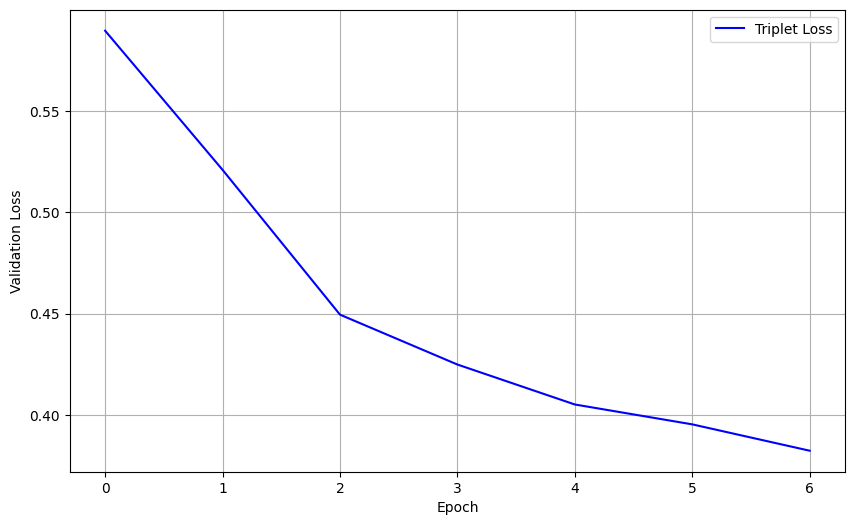

In [ ]:
# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label='Triplet Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid()
plt.show()

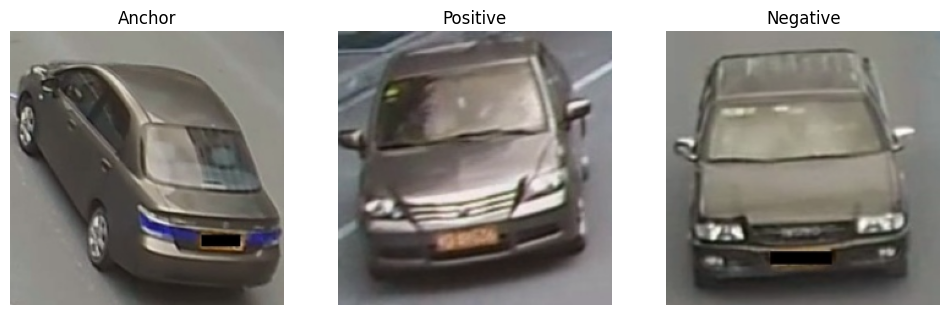

In [ ]:
'''this function visualizes a set of anchor, positive, and negative images from the training batch
and as you can see we have select from our batch the fourth images as an anchor and the image in index 3 of the positive
and at index 5 of the negative and yes we got good results, that mean my triplets sample are pretty good so far'''

def plot_embeddings(anchors, positives, negatives):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # anchor image
    axes[0].imshow(anchors[3])
    axes[0].set_title('Anchor')
    axes[0].axis('off')

    # positive image
    axes[1].imshow(positives[3])
    axes[1].set_title('Positive')
    axes[1].axis('off')

    # negative image
    axes[2].imshow(negatives[5])
    axes[2].set_title('Negative')
    axes[2].axis('off')

    plt.show()

plot_embeddings(train_anchors, train_positives, train_negatives)

In [ ]:
# Here I just take 10 sample from query sample and whole test images to check the top 5 rank images
sample_size = 10

# selecting random sample from my query
query_sample_files = random.sample(os.listdir(query_images_dir), sample_size)
test_sample_files = os.listdir(test_images_dir) # take the whole images from test

# Generate embeddings
def generate_embeddings(image_files, directory, model):
    embeddings = []
    for file_name in image_files:
        img_path = os.path.join(directory, file_name)
        img = load_and_preprocess_image(img_path)
        embedding = model.predict(np.expand_dims(img, axis=0))
        embeddings.append(embedding[0])
    return np.array(embeddings), image_files

# Generate embeddings for samples
query_embeddings, query_files = generate_embeddings(query_sample_files, query_images_dir, model)
test_embeddings, test_files = generate_embeddings(test_sample_files, test_images_dir, model)

In [ ]:
# I've saved my query and test embeddins
np.save("query_embeddings.npy", query_embeddings)
np.save("test_embeddings.npy", test_embeddings)

In [ ]:
# Generate embeddings for samples
query_embeddings, query_files = generate_embeddings(query_sample_files, query_images_dir, model)
test_embeddings, test_files = generate_embeddings(test_sample_files, test_images_dir, model)

In [ ]:
print("Query Embeddings Shape:", query_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)

Query Embeddings Shape: (10, 128)
Test Embeddings Shape: (11579, 128)


In [ ]:
# here I compute the Euclidean distances between all pairs of query and test embeddings, and i produce a distance matrix.
from sklearn.metrics import pairwise_distances

top_k = 30

distances = pairwise_distances(query_embeddings, test_embeddings, metric='euclidean')

top_k_indices = np.argsort(distances, axis=1)[:, :top_k]

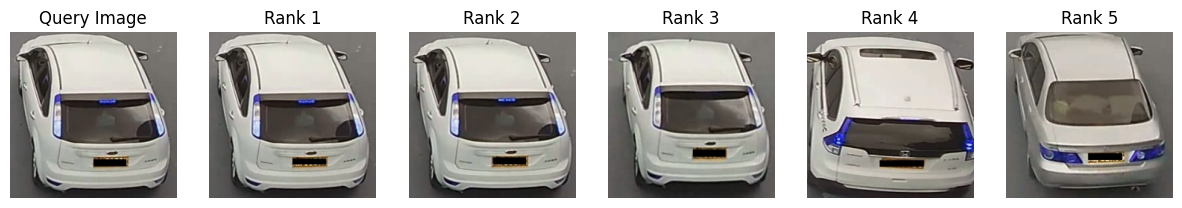

In [ ]:
# I visualizes the query image alongside its top K matches from the test dataset
def display_top_matches(query_image, top_k_indices, query_files, test_files, top_k=5):
    query_index = query_files.index(query_image)

    top_matches = top_k_indices[query_index][:top_k]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, top_k + 1, 1)
    plt.imshow(load_and_preprocess_image(os.path.join(query_images_dir, query_image)))
    plt.title("Query Image")
    plt.axis('off')

    for rank, index in enumerate(top_matches):
        plt.subplot(1, top_k + 1, rank + 2)
        plt.imshow(load_and_preprocess_image(os.path.join(test_images_dir, test_files[index])))
        plt.title(f"Rank {rank + 1}")
        plt.axis('off')

    plt.show()

if query_files:
    display_top_matches(query_files[4], top_k_indices, query_files, test_files, top_k=5)

    '''I almost have checked all 10 query images and the results are somehow good, in most cases the model retrives similar images
    to our query which means it trained well but let's check that assumption ;)'''

In [ ]:
# Retrieve the filenames
query_filenames = os.listdir(query_images_dir)
test_filenames = os.listdir(test_images_dir)

query_filenames.sort()
test_filenames.sort()

In [ ]:
top_k = 10  # Set to 10 to focus on the top 10 retrieved items

top_k_indices = np.argsort(distances, axis=1)[:, :top_k]

def calculate_ap_and_ranks(query_embedding, query_id, test_embeddings, test_filenames):
    scores = [] # will store the similarity values between query and test embeddings
    all_labels = []

    for test_embedding, test_filename in zip(test_embeddings, test_filenames):
        test_id = test_filename[:4]  # here i just take the first 4 digits as ID
        # Calculate cosine similarity
        score = np.dot(query_embedding, test_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(test_embedding))
        scores.append(score)

        label = int(test_id == query_id)  # Relevant if IDs match
        all_labels.append(label)

    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = [all_labels[idx] for idx in sorted_indices[:top_k]]  # Only consider top 10 labels

    # calculate Average Precision
    ap = average_precision_score(sorted_labels, scores[:top_k])

    # Check ranks of relevant images
    relevant_ranks = [idx for idx, label in enumerate(sorted_labels) if label == 1]

    return ap, relevant_ranks

def mAP_cal(query_embeddings, test_embeddings, query_filenames, test_filenames):
    all_scores = []
    relevant_counts = []

    for i in range(len(query_embeddings)):
        query_embedding = query_embeddings[i]
        query_id = query_filenames[i][:4]  # Extract ID from query filename
        # calculate the AP and rank for our query
        ap, relevant_ranks = calculate_ap_and_ranks(query_embedding, query_id, test_embeddings, test_filenames)

        all_scores.append(ap)
        relevant_counts.append(sum(1 for rank in relevant_ranks if rank < top_k))  # Count relevant images in top_k

        print(f"Query {i}: AP = {ap:.4f}, Relevant Ranks = {relevant_ranks}")

    mean_average_precision = np.mean(all_scores)
    return mean_average_precision

# Calculate mAP at rank 10
map_rank_10 = mAP_cal(query_embeddings, test_embeddings, query_files, test_files)
print(f"Mean Average Precision (mAP): {map_rank_10:.4f}")

Query 0: AP = 0.2361, Relevant Ranks = [0, 1]
Query 1: AP = 0.4167, Relevant Ranks = [0, 1]
Query 2: AP = 0.4405, Relevant Ranks = [0, 1, 2, 6]
Query 3: AP = 0.4762, Relevant Ranks = [0, 1, 2, 5]
Query 4: AP = 0.5012, Relevant Ranks = [0, 1, 2, 4]
Query 5: AP = 0.5139, Relevant Ranks = [0, 2, 5]
Query 6: AP = 0.3696, Relevant Ranks = [0, 1, 2, 3]
Query 7: AP = 0.4405, Relevant Ranks = [0, 1, 3, 4]
Query 8: AP = 0.2619, Relevant Ranks = [0, 1, 3]
Query 9: AP = 0.8755, Relevant Ranks = [0, 1, 2, 3, 4, 5, 6, 7]
Mean Average Precision (mAP): 0.4532


The above results of the Average Precision calculations for my ten queries indicate varying levels of retrieval effectiveness, with a mean Average Precision (mAP) of 0.4532. considering, Query 9 achieved the highest AP of 0.8755, showing a strong retrieval performance by successfully identifying multiple relevant ranks, while Queries 0 and 8 showed the lowest APs of 0.2361 and 0.2619, respectively, indicating limited relevance among the top retrieved items. The presence of relevant ranks in most queries show that the model is generally effective in distinguishing between similar vehicles, with some queries benefiting from better feature representations than others.